# Context

Uma rede de hoteis possui uma base de dados de reservas feitas por clientes de Julho de 2015 a Agosto de 2017. EM particular, essa base de dados relaciona as caracteristicas da reserva a quais delas foram canceladas ou nao pelos clientes. A empresa deseja buscar por insights que possam fornecer uma estrategia para evitar cancelamentos e também construir um modelo preditivo que possa antecipar esses cancelamentos, de modo que a empresa tenha tempo hábil para agir com ações de retenção.

Aqui apresento a analise dos dados disponibilizados e um modelo de classificacao para prever cancelamentos de reservas pelos clientes. Esse notebook e composto pelas seguintes secoes:

- Exploratory Data Analysis
- Feature Engineering
    - Missing values
    - Dummy variables
    - Train and test sets
- Model selection
    - Random Forest
    - XGBoost
- Further improvements
- Conclusions

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# Exploratory Data Analysis

Vamos comecar carregando o conjunto de dados disponivel e calculando algumas estatisticas descritivas.

In [3]:
df = pd.read_csv('cancellation_prediction.csv')
df.head()

,type,cancellation,days_between_booking_arrival,year_arrival_date,month_arrival_date,week_number_arrival_date,day_of_month_arrival_date,num_weekend_nights,num_workweek_nights,num_adults,...,num_previous_stays,reserved_room,changes_between_booking_arrival,deposit_policy,id_travel_agency_booking,id_person_booking,customer_type,avg_price,required_car_parking_spaces,total_of_special_requests
0,Fancy Hotel,0,342,2015,July,27,1,0,0,2,...,0,C,3,No Deposit,NaN,NaN,0,0.0,0,0
1,Fancy Hotel,0,737,2015,July,27,1,0,0,2,...,0,C,4,No Deposit,NaN,NaN,0,0.0,0,0
2,Fancy Hotel,0,7,2015,July,27,1,0,1,1,...,0,A,0,No Deposit,NaN,NaN,0,75.0,0,0
3,Fancy Hotel,0,13,2015,July,27,1,0,1,1,...,0,A,0,No Deposit,304.0,NaN,0,75.0,0,0
4,Fancy Hotel,0,14,2015,July,27,1,0,2,2,...,0,A,0,No Deposit,240.0,NaN,0,98.0,0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 28 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   type                             119390 non-null  object 
 1   cancellation                     119390 non-null  int64  
 2   days_between_booking_arrival     119390 non-null  int64  
 3   year_arrival_date                119390 non-null  int64  
 4   month_arrival_date               119390 non-null  object 
 5   week_number_arrival_date         119390 non-null  int64  
 6   day_of_month_arrival_date        119390 non-null  int64  
 7   num_weekend_nights               119390 non-null  int64  
 8   num_workweek_nights              119390 non-null  int64  
 9   num_adults                       119390 non-null  int64  
 10  num_children                     119386 non-null  float64
 11  num_babies                       119390 non-null  int64  
 12  br

In [9]:
df[[x for x in df.columns if 'date' not in x]].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cancellation,119390.0,0.370416,0.482918,0.0,0.00,0.000,1.0,1.0
days_between_booking_arrival,119390.0,104.011416,106.863097,0.0,18.00,69.000,160.0,737.0
num_weekend_nights,119390.0,0.927599,0.998613,0.0,0.00,1.000,2.0,19.0
num_workweek_nights,119390.0,2.500302,1.908286,0.0,1.00,2.000,3.0,50.0
num_adults,119390.0,1.856403,0.579261,0.0,2.00,2.000,2.0,55.0
num_children,119386.0,0.103890,0.398561,0.0,0.00,0.000,0.0,10.0
num_babies,119390.0,0.007949,0.097436,0.0,0.00,0.000,0.0,10.0
market_segment,119390.0,2.467577,1.420967,0.0,2.00,2.000,3.0,7.0
distribution_channel,119390.0,1.702019,0.681400,0.0,2.00,2.000,2.0,4.0
repeated_guest,119390.0,0.031912,0.175767,0.0,0.00,0.000,0.0,1.0


Nessa visualizacao inicial, vemos que o conjunto de dados eh composto por 119390 entradas com dados de reservas na rede de hoteis. Cada uma das reservas eh descrita por 28 caracteristicas, numericas e categoricas, dentre as quais se apresenta uma variavel binaria "cancellation" que corresponde ao cancelamento ou nao da reserva. Entre as variaveis numericas, "days_between_booking_arrival" e "avg_price" sao as que apresentam distribuicoes mais extensas de valores, enquanto as demais correspondem a variaveis inteiras com medianas entre 0 e 2.

Nota-se tambem que algumas dessas variaveis apresentam missing values. Quais sao elas?

In [15]:
df[df.columns[df.isnull().sum()!=0]].isnull().sum()

num_children                     4
country                        488
id_travel_agency_booking     16340
id_person_booking           112593
dtype: int64

Procederemos com a imputacao dos dados faltantes na secao de pre-processamento.

Outro aspecto importante eh checar se ha dados de reserva duplicados.

In [26]:
df[df.duplicated()]

,type,cancellation,days_between_booking_arrival,year_arrival_date,month_arrival_date,week_number_arrival_date,day_of_month_arrival_date,num_weekend_nights,num_workweek_nights,num_adults,...,num_previous_stays,reserved_room,changes_between_booking_arrival,deposit_policy,id_travel_agency_booking,id_person_booking,customer_type,avg_price,required_car_parking_spaces,total_of_special_requests
5,Fancy Hotel,0,14,2015,July,27,1,0,2,2,...,0,A,0,No Deposit,240.0,NaN,0,98.00,0,1
22,Fancy Hotel,0,72,2015,July,27,1,2,4,2,...,0,A,1,No Deposit,250.0,NaN,0,84.67,0,1
43,Fancy Hotel,0,70,2015,July,27,2,2,3,2,...,0,E,0,No Deposit,250.0,NaN,0,137.00,0,1
138,Fancy Hotel,1,5,2015,July,28,5,1,0,2,...,0,D,0,No Deposit,240.0,NaN,0,97.00,0,0
200,Fancy Hotel,0,0,2015,July,28,7,0,1,1,...,0,A,0,No Deposit,240.0,NaN,0,109.80,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119349,Hotel,0,186,2017,August,35,31,0,3,2,...,0,D,0,No Deposit,9.0,NaN,0,126.00,0,2
119352,Hotel,0,63,2017,August,35,31,0,3,3,...,0,D,0,No Deposit,9.0,NaN,2,195.33,0,2
119353,Hotel,0,63,2017,August,35,31,0,3,3,...,0,D,0,No Deposit,9.0,NaN,2,195.33,0,2
119354,Hotel,0,63,2017,August,35,31,0,3,3,...,0,D,0,No Deposit,9.0,NaN,2,195.33,0,2


Vemos que 33246 reservas sao apresentadas como duplicadas, o que pode ocorrer devido a possiveis falhas no sistema de reservas ou mesmo erro humano no gerenciamento do banco de dados. Dados duplicados podem introduzir um vies adicional em modelos preditivos, portanto eh necessario que se exclua reservas duplicadas em nossas analises. Todavia, como ha um numero muito grande de dados faltando na variavel de identificacao da pessoa fazendo a reserva ("id_person_booking") eh dificil saber se tais reservas duplicadas correspondem de fato a um erro no banco de dados ou apenas o acaso de pessoas diferentes fazendo reservas identicas.

Como uma medida conservativa, vamos excluir apenas aquelas reservas duplicadas que possuem identificacao da pessoa.

In [33]:
df = df[~((df.duplicated())&(df.id_person_booking.notnull()))]

Como essa analise foca principalmente no cancelamento das reservas dos hospedes, vamos avaliar alguns aspectos importantes sobre cancelamento nesse conjunto de dados e como essa variavel depende do tempo e de relacoes com outras variaveis.

In [35]:
df.cancellation.value_counts()/df.cancellation.shape[0]

0    0.629641
1    0.370359
Name: cancellation, dtype: float64

Considerando o conjunto de dados, ha um pequeno desbalanco entre o numero de reservas que foram canceladas (cancellation = 1), com uma proporcao de 63% do total de reservas, e as que nao foram (cancellation = 0), com uma proporcao de 37%.

Vejamos agora a variacao temporal do numero de cancelamentos em funcao da data de chegada na reserva.

In [87]:
d = {'January': 1,
     'February': 2,
     'March': 3,
     'April': 4,
     'May': 5,
     'June': 6,
     'July': 7,
     'August': 8,
     'September': 9,
     'October': 10,
     'November': 11,
     'December': 12}

df['month_arrival_date_index'] = df['month_arrival_date'].map(d)
df['arrival_date'] = pd.to_datetime(dict(year=df.year_arrival_date, month=df.month_arrival_date_index, day=df.day_of_month_arrival_date))

df_cancel = df.groupby('arrival_date', as_index=True).cancellation.agg(frac_cancel_daily='mean')
df_cancel['rolling_avg_cancel'] = df_cancel.frac_cancel_daily.rolling(30).mean()

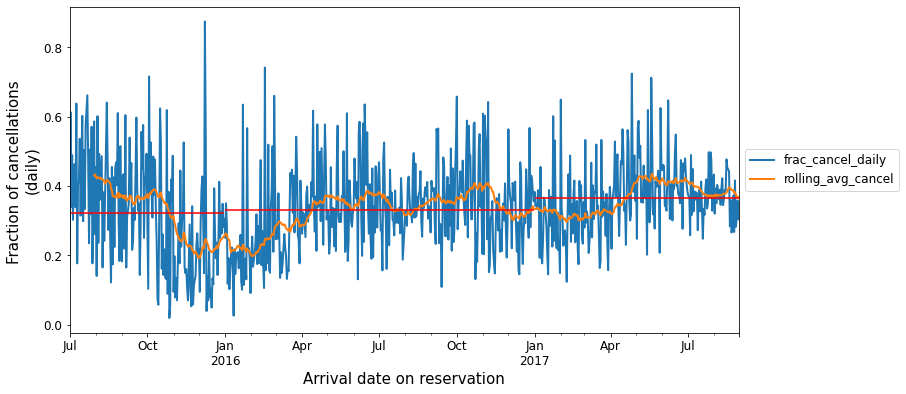

In [89]:
#Plotar valores de numero de cancelamentos diarios e media movel para 30 dias
ax = df_cancel.plot(
    linewidth=2,
    figsize=(12, 6)
)

#Plotar as medias de cancelamento anuais para 2015, 2016 e 2017
ax.hlines(y=df_cancel.loc[:'2015-12-31'].frac_cancel_daily.mean(), 
          xmin='2015-07-01', xmax='2015-12-31', linewidth=1.5, color='r')
ax.hlines(y=df_cancel.loc['2016-01-01':'2016-12-31'].frac_cancel_daily.mean(), 
          xmin='2016-01-01', xmax='2016-12-31', linewidth=1.5, color='r')
ax.hlines(y=df_cancel.loc['2017-01-01':].frac_cancel_daily.mean(), 
          xmin='2017-01-01', xmax='2017-08-31',linewidth=1.5, color='r')


ax.set_xlabel("Arrival date on reservation", fontsize=15) 
ax.set_ylabel("Fraction of cancellations \n(daily)", fontsize=15) 

ax.tick_params(axis='both', which='major', labelsize=12)

ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), fontsize=12)

O grafico acima mostra a fracao diaria de cancelamentos, ou a proporcao das reservas para aquele dia que foram canceladas, ao longo do tempo, de Julho de 2015 a Agosto de 2017. Esse resultado pode tambem ser interpretado como a probabilidade de que uma reserva aleatoriamente escolhida em um dado dia de chegada veio a ser cancelada pelo cliente. 

Algumas observacoes importantes na analise dessa serie temporal:

1. As variacoes bruscas das fracoes diarias de cancelamentos indicam pouca autocorrelacao na serie temporal, ou em outras palavras, a fracao de cancelamentos de um determinado dia eh pouco afetada pela fracao de cancelamentos dos dias anteriores. Esse sera um aspecto importante para nossos modelos preditivos mais a frente.

2. Vemos tambem pelo smoothing da variacao temporal, obtido atraves da media movel para 30 dias (em laranja), que ha uma sazonalidade na probabilidade de cancelamentos ao longo do ano. Ha picos de cancelamento entre os meses de Abril a Outubro, enquanto os periodos de Novembro a Marco correspondem a periodos de queda nas probabilidades diarias de cancelamentos. Tais picos de cancelamento sugerem periodos de foco para o negocio, onde estrategias visando a retencao dessas reservas poderiam trazer um bom retorno (descontos nos valores de reserva ou beneficios para clientes que concretizem a reserva feita).

3. Ha uma leve tendencia de aumento na media de probabilidade de cancelamentos (indicadas pelas linhas vermelhas horizontais) no ano de 2017 comparada as medias em 2016 e 2015. Contudo, eh necessario ter cautela nessa conclusao, uma vez que o conjunto de dados para 2017 eh limitado ao periodo de Janeiro a Setembro e o de 2015, de Julho a Dezembro.

Procedendo com a analise temporal das fracoes de cancelamentos, vejamos como essa variavel eh afetada pelo dia da semana, dia do mes ou semana do ano marcados para chegada nessas reservas.

In [91]:
df_cancel['fulldate'] = df_cancel.index

dic_day = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
df_cancel['dayofweek'] = df_cancel['fulldate'].dt.dayofweek.map(dic_day)

df_cancel['dayofmonth'] = df_cancel['fulldate'].dt.day
df_cancel['weekofyear'] = df_cancel['fulldate'].dt.isocalendar().week

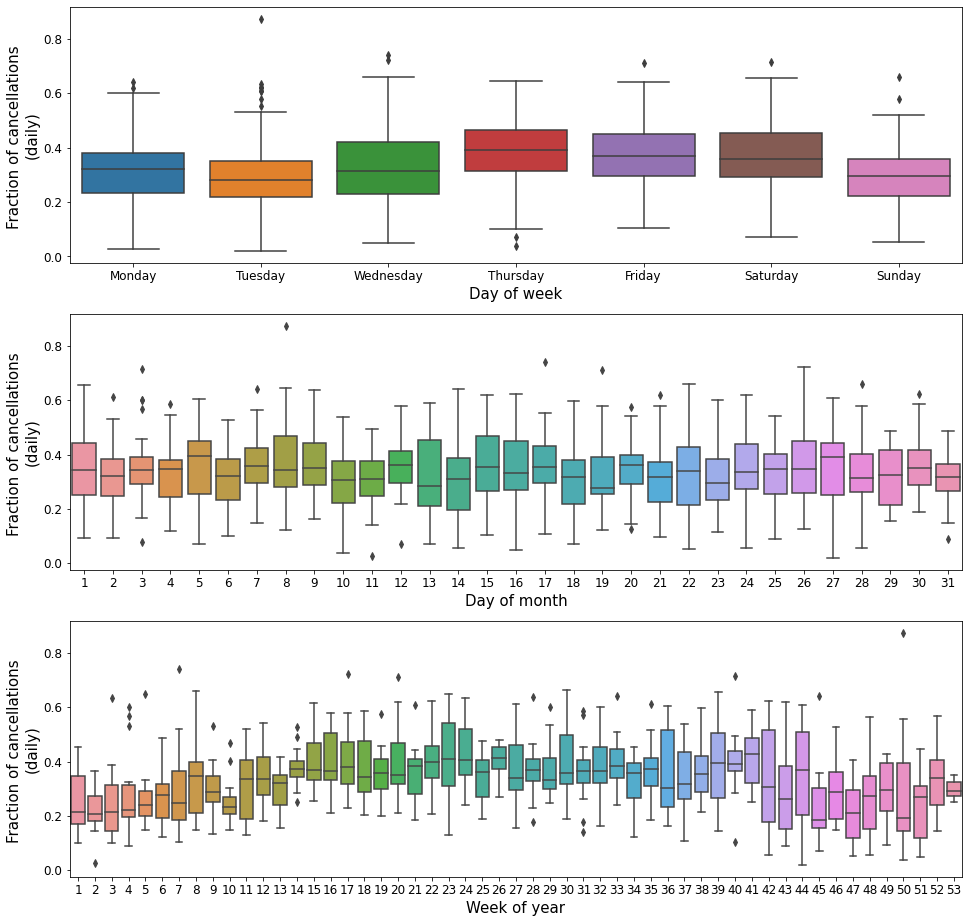

In [92]:
lbs = ['Day of week', 'Day of month', 'Week of year']

fig,axs = plt.subplots(3, 1, figsize=(16,16))

sns.boxplot(x="dayofweek", y="frac_cancel_daily", data=df_cancel, 
                 order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], ax=axs[0])

sns.boxplot(x="dayofmonth", y="frac_cancel_daily", data=df_cancel, ax=axs[1])

sns.boxplot(x="weekofyear", y="frac_cancel_daily", data=df_cancel, ax=axs[2])

for i in range(3):
    axs[i].set_xlabel(lbs[i], fontsize=15)
    axs[i].set_ylabel("Fraction of cancellations \n(daily)", fontsize=15)
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    

Os graficos acima mostram que nao parece haver impactos significativos na probabilidades de cancelamentos dependentes do dia da semana ou do dia do mes (primeiro e segundo graficos) que a reserva marcava para a chegada. Em relacao a semana do ano (terceiro grafico), aumentos nos numeros medios de cancelamento sao mais visiveis entre as semanas 14 e 44 (Abril a Outubro), em concordancia com a analise anterior da serie temporal. Vemos assim que semana do ano pode ser um preditor importante para cancelamentos de reserva.

Como as outras variaveis na reserva impactam seu possivel cancelamento?

# Feature engineering

## Missing values

Vamos voltar a olhar para as variaveis com dados faltando.

In [146]:
df[df.columns[df.isnull().sum()!=0]].isnull().sum()

num_children                     4
country                        481
id_travel_agency_booking     14686
id_person_booking           112593
dtype: int64

In [147]:
df[df.num_children.isnull()]

,type,cancellation,days_between_booking_arrival,year_arrival_date,month_arrival_date,week_number_arrival_date,day_of_month_arrival_date,num_weekend_nights,num_workweek_nights,num_adults,...,changes_between_booking_arrival,deposit_policy,id_travel_agency_booking,id_person_booking,customer_type,avg_price,required_car_parking_spaces,total_of_special_requests,month_arrival_date_index,arrival_date
40600,Hotel,1,2,2015,August,32,3,1,0,2,...,0,No Deposit,NaN,NaN,2,12.0,0,1,8,2015-08-03
40667,Hotel,1,1,2015,August,32,5,0,2,2,...,0,No Deposit,14.0,NaN,2,12.0,0,1,8,2015-08-05
40679,Hotel,1,1,2015,August,32,5,0,2,3,...,0,No Deposit,NaN,NaN,2,18.0,0,2,8,2015-08-05
41160,Hotel,1,8,2015,August,33,13,2,5,2,...,0,No Deposit,9.0,NaN,2,76.5,0,1,8,2015-08-13


Para o caso dos dados faltando na variavel numero de criancas, como o numero de instancias eh bem pequeno (quatro), desconsiderarmos essas instancias nao tera um impacto grande sobre nosso modelo. 

In [149]:
df = df[~df.num_children.isnull()]

Para as tres variaveis restantes, o numero de reservas sem esses dados eh muito grande, de modo que descarta-las nao eh uma opcao. Como tambem parece ser dificil inferir os valores dessas variaveis atreves de outras variaveis para uma mesma reserva, o mais conservador aqui eh criar categorias de "nao-identificados".

In [151]:
df.country.fillna('nonIDcountry',inplace=True)
df.id_travel_agency_booking.fillna('nonIDagency',inplace=True)
df.id_person_booking.fillna('nonIDperson',inplace=True)

/tmp/ipykernel_199827/285370354.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.country.fillna('nonIDcountry',inplace=True)
/tmp/ipykernel_199827/285370354.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.id_travel_agency_booking.fillna('nonIDagency',inplace=True)
/tmp/ipykernel_199827/285370354.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.id_person_booking.fillna('nonIDperson',inplace=True)


In [152]:
df.isnull().sum()

type                               0
cancellation                       0
days_between_booking_arrival       0
year_arrival_date                  0
month_arrival_date                 0
week_number_arrival_date           0
day_of_month_arrival_date          0
num_weekend_nights                 0
num_workweek_nights                0
num_adults                         0
num_children                       0
num_babies                         0
breakfast                          0
country                            0
market_segment                     0
distribution_channel               0
repeated_guest                     0
num_previous_cancellations         0
num_previous_stays                 0
reserved_room                      0
changes_between_booking_arrival    0
deposit_policy                     0
id_travel_agency_booking           0
id_person_booking                  0
customer_type                      0
avg_price                          0
required_car_parking_spaces        0
t

Mostrando que nao restam mais missing values em nosso conjunto de dados.

## Dummy variables

Vamos agora transformar as variaveis categoricas em dummy variables para que possam ser usada como input em nossos modelos. Antes disso precisamos efetuar ajustes aos valores de algumas das variaveis.

In [153]:
df.type = df.type.str.lower().str.replace(" ", "_")
df.breakfast = df.breakfast.astype('int')
df.deposit_policy =  df.deposit_policy.str.lower().str.replace(" ", "_")

catdf = df[['type','country','market_segment','distribution_channel','reserved_room','deposit_policy',
           'id_travel_agency_booking','id_person_booking','customer_type']]
numdf = df[df.columns[~df.columns.isin(['type','country','market_segment','distribution_channel','reserved_room','deposit_policy',
           'id_travel_agency_booking','id_person_booking','customer_type'])]]

/tmp/ipykernel_199827/685886137.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.type = df.type.str.lower().str.replace(" ", "_")
/tmp/ipykernel_199827/685886137.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.breakfast = df.breakfast.astype('int')
/tmp/ipykernel_199827/685886137.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [155]:
dummycatdf = pd.get_dummies(catdf.astype(str),drop_first=True)

In [156]:
dummycatdf.shape

(117698, 887)

In [163]:
moddf = pd.concat([numdf,dummycatdf],axis=1)

In [164]:
moddf.shape

(117698, 908)

## Train and test sets

No caso em questao, gostariamos de obter um modelo que fosse capaz de prever se uma dada reserva sera ou nao cancelada, a partir das caracteristicas desta reserva. Nesse caso, faz sentido que os conjuntos de treino e teste sejam particoes aleatorias do nosso conjunto total de dados (respeitando as proporcoes de estratificacao nos nossos labels, no caso a variavel cancellation). 

Apesar desse conjunto de dados representar uma progressao no tempo desses cancelamentos, esse problema eh diferente de uma previsao em serie temporal, onde, a partir do historico de uma dada variavel que muda com o tempo, gostariamos de prever seu comportamento para os tempos futuros. Nesse caso, uma particao em treino e teste que respeitasse a historia de variacao temporal dos dados seria mais adequada.

A rapida variacao das fracoes diarias de cancelamento (veja grafico acima) tambem indica que a correlacao temporal entre instancias proximas (autocorrelacao) nao eh significativa, de modo que podemos assumir que tais amostras sao suficientemente independentes.

Dessa forma, procedemos abandonando features que nao devem ser relevantes para nossa analise e dividindo o conjunto de dados em treino e teste, com uma proporcao de 20% para o conjunto de teste.

In [166]:
numdf.columns

Index(['cancellation', 'days_between_booking_arrival', 'year_arrival_date',
       'month_arrival_date', 'week_number_arrival_date',
       'day_of_month_arrival_date', 'num_weekend_nights',
       'num_workweek_nights', 'num_adults', 'num_children', 'num_babies',
       'breakfast', 'repeated_guest', 'num_previous_cancellations',
       'num_previous_stays', 'changes_between_booking_arrival', 'avg_price',
       'required_car_parking_spaces', 'total_of_special_requests',
       'month_arrival_date_index', 'arrival_date'],
      dtype='object')

In [168]:
moddf = moddf.drop(['year_arrival_date',
                     'month_arrival_date',
                     'day_of_month_arrival_date',
                     'month_arrival_date_index', 
                     'arrival_date'],axis=1)

In [170]:
from sklearn.model_selection import train_test_split

labels = moddf['cancellation']
features = moddf.drop(['cancellation'],axis=1)

Xtrain, Xtest, ytrain, ytest = train_test_split(features, labels, test_size=0.2, random_state=42)

# Model selection

In [176]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score

Vamos testar dois modelos frequentemente usados em tarefas de classificacao e comparar seus resultados. Faremos a comparacao por F1-score da performance no conjunto de treino e performance em validacao cruzada nesse mesmo conjunto para avaliar overfitting do modelo. Em seguida avaliaremos F1-score e matriz de confusao para o conjunto de teste.

Os resultados dos diferentes modelos serao comparadas para que o melhor seja selecionado.

## Random Forest

In [177]:
rfc = RandomForestClassifier(random_state=42)

rfc.fit(Xtrain,ytrain)

print(f1_score(ytrain,rfc.predict(Xtrain)))
print(cross_val_score(rfc, Xtrain, ytrain, scoring='f1', cv=5).mean())

0.9940514770484956
0.8337008231520467


A diferenca grande entre performance no conjunto de treino e na validacao cruzada com 5 particoes indica overfitting do conjunto de treino. Isso pode fazer com que o modelo nao generalize bem para novos conjuntos de dados.

Uma forma de tentar evitar overfitting em Random Forests eh limitar a profundidade das arvores, aumentando o numero de estimadores para evitar underfit.

In [180]:
rfc2 = RandomForestClassifier(n_estimators=500, max_depth=6, random_state=42)

rfc2.fit(Xtrain,ytrain)

print(f1_score(ytrain,rfc2.predict(Xtrain)))
print(cross_val_score(rfc2, Xtrain, ytrain, scoring='f1', cv=5).mean())

0.5170143402015724
0.5190681591837849


Como vemos, esta tentativa de ajuste dos hiperparametros resultou num modelo com pior performance, em comparacao com o modelo anterior (rfc). Uma maneira mais adequada de achar essa otimizacao seria utilizar uma combinacao de RandomSearchCV e GridSearchCV para encontrar qual o conjunto de hiperparametros conferiria a melor performance.

Como o modelo anterior performa no conjunto de teste?

In [187]:
print(confusion_matrix(ytest,rfc.predict(Xtest))/ytest.shape[0])
print(f1_score(ytest,rfc.predict(Xtest)))

[[0.5864486  0.04001699]
 [0.07429907 0.29923534]]
0.8396209547648846


O modelo teve uma performance similar no conjunto de teste em comparacao com a validacao cruzada com 5 particoes. Um F1-score de aproximadamente 0.84 (medindo a media harmonica entre precision e recall) parece uma boa performance para um modelo desse tipo, considerando que nao houve ajuste de hiperparametros nesse caso.

A matriz de confusao mostra que o modelo apresenta boa performance em prever a classe 0 e uma performance razoavelmente pior em prever a classe 1, com uma proporcao 0.04 de falsos positivos e 0.07 de falsos negativos.

Vamos checar agora como um outro classificador performa sobre esse conjunto de dados.

## XGBoost

In [190]:
xgb = XGBClassifier(random_state=42)

xgb.fit(Xtrain,ytrain)
cvxgb = cross_val_score(xgb, Xtrain, ytrain, scoring='f1', cv=5)

[17:39:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ldiasfer/anaconda3/envs/survival/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ldiasfer/anaconda3/envs/survival/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:41:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ldiasfer/anaconda3/envs/survival/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ldiasfer/anaconda3/envs/survival/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:42:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ldiasfer/anaconda3/envs/survival/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ldiasfer/anaconda3/envs/survival/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:43:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ldiasfer/anaconda3/envs/survival/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ldiasfer/anaconda3/envs/survival/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:44:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ldiasfer/anaconda3/envs/survival/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ldiasfer/anaconda3/envs/survival/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:45:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [191]:
print(f1_score(ytrain,xgb.predict(Xtrain)))
print(cvxgb.mean())

0.829328753826626
0.8138513683401571


O modelo apresenta um bom score no conjunto de treino e na validacao cruzada, com apenas uma pequena diferenca entre os dois, indicando boa generalizacao para novos conjuntos.

Sera possivel melhorar a performance introduzindo uma limitacao nos hiperparametros?

In [192]:
xgb2 = XGBClassifier(n_estimators=1000, max_depth=6, random_state=42)

xgb2.fit(Xtrain,ytrain)
cvxgb2 = cross_val_score(xgb2, Xtrain, ytrain, scoring='f1', cv=5)

/home/ldiasfer/anaconda3/envs/survival/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ldiasfer/anaconda3/envs/survival/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:51:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ldiasfer/anaconda3/envs/survival/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ldiasfer/anaconda3/envs/survival/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:03:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ldiasfer/anaconda3/envs/survival/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ldiasfer/anaconda3/envs/survival/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:14:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ldiasfer/anaconda3/envs/survival/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ldiasfer/anaconda3/envs/survival/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:24:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ldiasfer/anaconda3/envs/survival/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ldiasfer/anaconda3/envs/survival/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:34:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/ldiasfer/anaconda3/envs/survival/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ldiasfer/anaconda3/envs/survival/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:44:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [193]:
print(f1_score(ytrain,xgb2.predict(Xtrain)))
print(cvxgb2.mean())

0.9313489457941198
0.8338878524405423


O ajuste dos hiperparametros levou a um aumento de 0.02 do F1-score na validacao cruzada. O score tambem aumentou no conjunto de treino, aumentando a distancia nos scores do treino e da avaliacao cruzada, o que sugere tendencia de overfit do conjunto de treino. Para a performance no conjunto de teste, temos:

In [196]:
print(confusion_matrix(ytest,xgb2.predict(Xtest))/ytest.shape[0])
print(f1_score(ytest,xgb2.predict(Xtest)))

[[0.57425658 0.05220901]
 [0.06677995 0.30675446]]
0.837557269616656


O XGBoost com ajuste de hiperparametros (xgb2) apresenta uma boa performance no conjunto de teste, com um F1-score de aproximadamente 0.84. Em comparacao com o melhor modelo de Random Forest (rfc), com um F1-score muito similar, o modelo xgb2 apresenta uma classificacao ligeiramente melhor na classe 1 e ligeiramente pior na classe 2. O xgb2 tambem apresenta uma diferenca menor entre performances de treino e validacao cruzada no treino, em comparacao com o modelo rfc, indicando menor overfit no conjunto de treino.

Podemos testar tambem como esse modelo performa em comparacao com um benchmark aleatorio. Para um modelo nulo aleatorio, poderiamos estabelecer que a classe de cancelamento de uma nova instancia seria 0 ou 1 com uma probabilidade equivalente a proporcao dessas duas classes em ytrain. 

Para esse benchmark, a metrica ROC-AUC equivale a aproximadamente 0.5, de modo que um modelo que apresente uma ROC-AUC maior que 0.5 eh melhor que o modelo naive aleatorio. Temos:

In [203]:
print(ytrain.value_counts()/ytrain.shape[0])
print(ytrain.shape[0])
print(ytest.shape[0])

yrand = np.random.choice(2,ytest.shape[0],
            p=[(ytrain.value_counts()/ytrain.shape[0]).iloc[0],(ytrain.value_counts()/ytrain.shape[0]).iloc[1]])

0    0.630462
1    0.369538
Name: cancellation, dtype: float64
94158
23540


In [205]:
from sklearn.metrics import roc_auc_score

print(roc_auc_score(ytest,yrand))
print(roc_auc_score(ytest,xgb2.predict(Xtest)))

0.5030752823249036
0.8689412209671243


Assim, vemos que o modelo xgb2 performa substancialmente melhor que o benchmark.

# Further Improvements

Algumas estrategias poderiam ser adotadas na busca de melhorar a performance do modelo. Essas estrategias foram aqui testadas apenas de maneira preliminar devido a limitacao do tempo, mas sao apresentadas como possiveis proximos passos nessa analise.

    1. Uma possibilidade seria focar na reducao da dimensionalidade do conjunto de dados, uma vez que o numero de features salta para 908 apos a adicao das dummy variables. Uma primeira tentativa de reducao do numero de features por PCA (apos standardizacao das features) nao mostrou um cutoff claro atraves da analise da variancia explicada acumulada. Estabelecendo um cutoff de 80% da variancia explicada, foi possivel reduzir o numero de features para approximadamente 600. As features transformadas por componentes principais, entretanto, nao levaram a um ganho de performance significativo nos modelos de classificacao, pelo menos numa analise preliminar.
    
    Uma outra tentativa de reducao da dimensionalidade focaria no agrupamento de valores para algumas das features. As features "id_travel_agency_booking" e "id_person_booking" possuem um numero muito grande de identificadores que aparecem em apenas uma ou poucas reservas. Identificadores que apresentam um numero total de reservas menores que 10, por exemplo, poderiam ser agrupadoes em categorias "not-frequent-person" e "not-frequent-agency", reduzindo significativamente o numero de dummy variables associados a categorias raras nessas variaveis. Esse procedimento tambem se justifica pelo fato que a probabilidade de classe 0 no cancelamento para essas categorias pouco frequentes eh muito maior do que pra classe 1, mostrando que esse grupo apresenta certa coesao.
    
    Uma reducao drastica no numero de features, mantendo a variabilidade do conjunto de dados, poderia levar a uma melhora da performance do modelo.
    
    2. Outra possibilidade, enunciada na secao acima, seria implementar um ajuste mais rigoroso dos hiperparametros. Isso poderia ser feito em tres etapas: (i) escolha do modelo com mais potencial de melhora, atraves de uma selecao preliminar, (ii) implementacao de RandomSearchCV para busca em intervalos maiores do espaco de parametros e (iii) GridSearchCV nas proximidades do melhor conjunto de parametros identificada no item (ii).
    
    3. Uma vantagem de usar modelos de ensembles baseados em arvores de decisao, como Random Forest e XGBoost, eh que eles proporcionam medidas de importancia de features atraves da analise do conjunto de features mais utilizadas no ensemble, apos treinamento do modelo. Uma analise das importancias das features atribuidas ao modelo selecionado poderia prover mais insights para estrategias de intervencao do cliente, atuando para minimizar o numero de cancelamentos na rede de hoteis.

# Conclusion

A partir dessa analise, selecionamos o modelo XGBoost com ajuste de hiperparametros (xgb2) por apresentar boa performance no conjunto de teste e um menor overfitting, comparado com o melhor modelo de Random Forest. Esse modelo eh capaz de prever o cancelamento, com bom precision e recall, de novas instancias de reservas feitas por clientes na rede de hoteis. 

Consta tambem nessa analise uma exploracao dos dados fornecidos, indicando possiveis alternativas de intervencao preliminares, que podem ser complementadas com analise posterior das caracteristicas do modelo treinado (veja comentario sobre feature importances na secao anterior). Por fim, algumas possibilidades de melhorias no modelo sao listadas como proximos passos na implementacao.